<a href="https://colab.research.google.com/github/Nikhil172913832/gesture_canvas/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imutils

In [10]:
import tensorflow as tf
from imutils import paths

In [4]:
IMG_SIZE = 256

In [5]:
def unnormalize_and_scale_labels(keypoints, max_val):
    keypoints = tf.math.scalar_mul(max_val, tf.math.add(keypoints, 0.5))
    return keypoints

In [6]:
def read_tfrecord(example):
    # Create a dictionary describing the features.
    features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'image_mask': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([42], tf.float32), # [21, 2 reshaped to 42]
    }
    image_features = tf.io.parse_single_example(example, features)

    image = tf.io.decode_raw(image_features['image_raw'], out_type = tf.uint8)
    image = tf.reshape(image, [256, 256, 3])


    mask = tf.io.decode_raw(image_features['image_mask'], out_type = tf.uint8)
    mask = tf.reshape(mask, [256, 256, 1])
    mask = tf.dtypes.cast(mask, tf.float32)

    labels = tf.reshape(image_features['label'], [21, 2])
    labels = unnormalize_and_scale_labels(labels, IMG_SIZE)
    labels = tf.dtypes.cast(labels, tf.float32) # this step is crucial to prevent NaNs from appearing
    # note that mask have been scaled to range [0, 1]
    return image, tf.divide(mask, IMG_SIZE), labels


In [8]:
AUTO = tf.data.experimental.AUTOTUNE
def load_dataset(filenames):
    """
    Load each TFRecord
    """
    ignore_order = tf.data.Options()
    ignore_order.deterministic = False

    files = tf.data.Dataset.list_files(filenames)
    dataset = files.with_options(ignore_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=512, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_batched_dataset(filenames, batch_size):
    """
    Feeds batch to the fit function
    """
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def load_valid_dataset(filenames):
    """
    Load each TFRecord
    """
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    files = tf.data.Dataset.list_files(filenames)
    dataset = files.with_options(ignore_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=512, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_valid_dataset(filenames, batch_size):
    """
    Feeds batch to the fit function
    """
    dataset = load_valid_dataset(filenames)
    dataset = dataset.shuffle(2000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [11]:
tran_dir = "/content/drive/MyDrive/archive/train"
train_tfrecord_names = list(paths.list_files("/content/drive/MyDrive/archive/train"))

In [12]:
train_tfrecord_names

['/content/drive/MyDrive/archive/train/training_data_0.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_1.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_10.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_11.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_12.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_13.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_14.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_15.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_16.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_17.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_18.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_19.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_2.tfrecords',
 '/content/drive/MyDrive/archive/train/training_data_20.tfrecords',
 '/content/drive/MyDrive/archive/train/training_dat

In [13]:
loaded_ds = get_batched_dataset(train_tfrecord_names, 8)

In [14]:
loaded_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 21, 2), dtype=tf.float32, name=None))>

In [15]:
one_batch = next(iter(loaded_ds))#[:8]

In [17]:
POSE_PAIRS = [ [0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9],
               [9, 10], [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17],
               [17, 18], [18, 19], [19, 20] ]

def draw_keypoints(keypoints, img):
    keypoints = keypoints.astype(np.int32)
    # TODO: add a transfrom step if needed (for arbitrary image size)

    for pair in keypoints:
        if pair[0] < 0:
            continue
        cv2.circle(img, pair, 2, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)

    for pair in POSE_PAIRS:
        start = pair[0]
        end = pair[1]

        if keypoints[start][0] < 0 or keypoints[end][0] < 0:
            continue

        cv2.line(img, keypoints[start], keypoints[end], (0, 0, 255), 1)
    return img

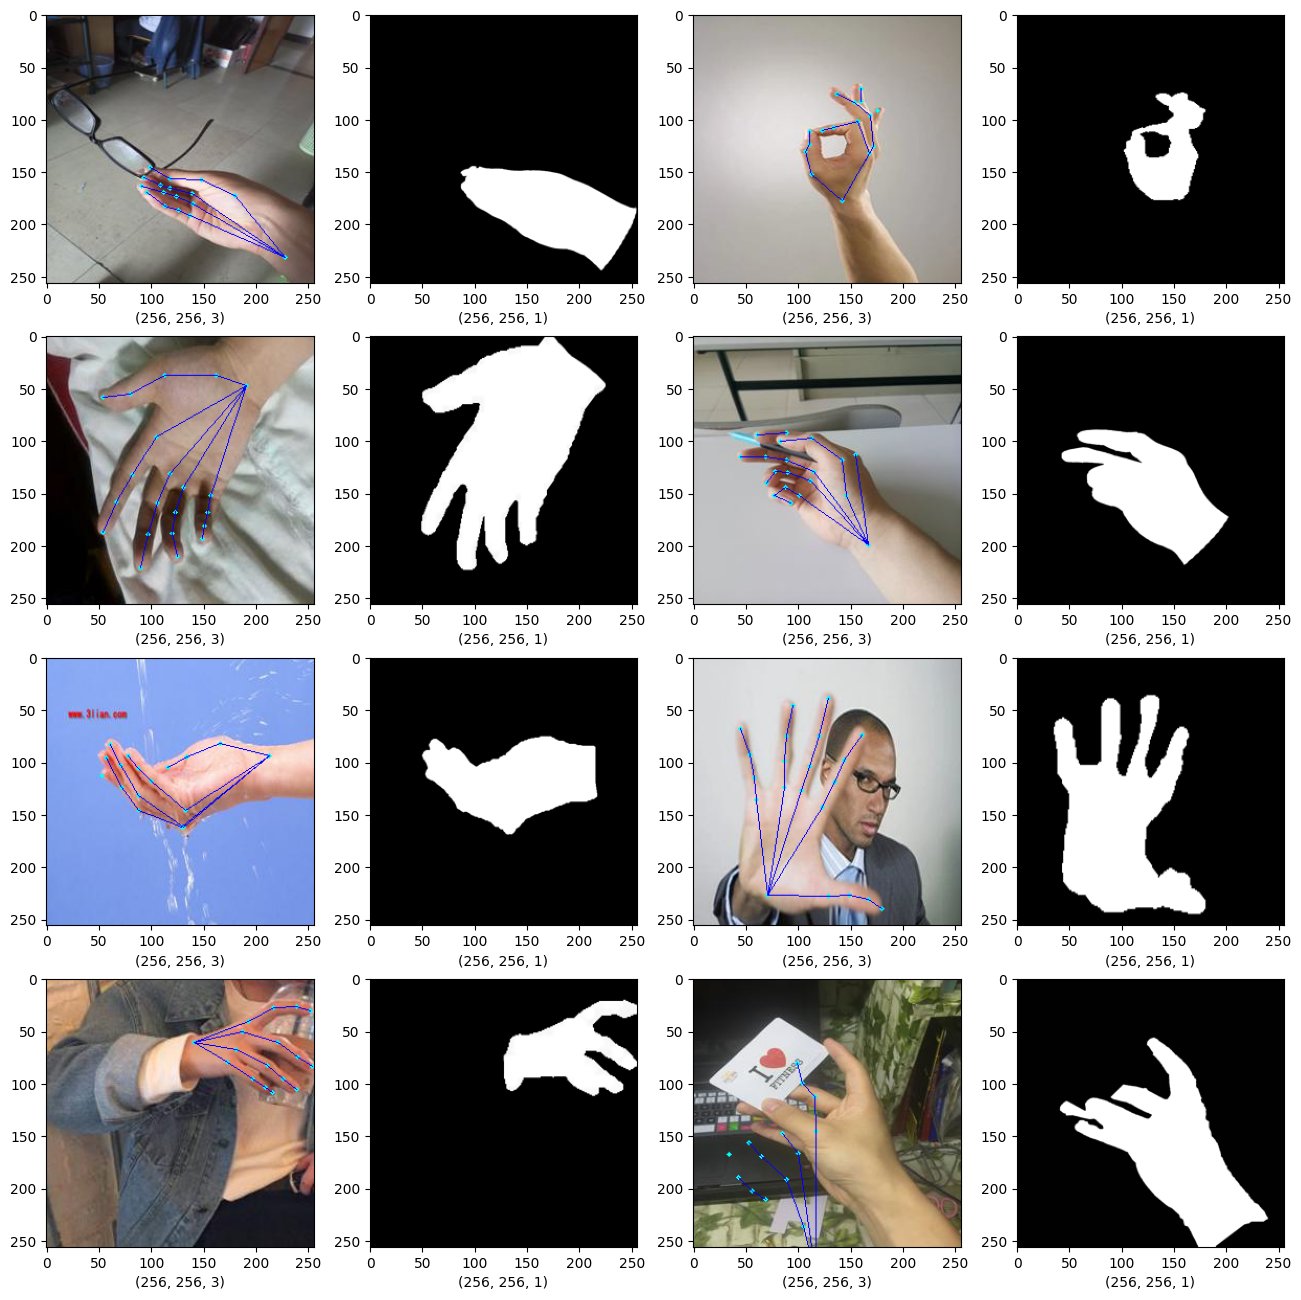

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

f, axs = plt.subplots(4, 4, figsize=(16, 16))
for num, (img, mask, json) in enumerate(zip(one_batch[0], one_batch[1], one_batch[2])):
    img = np.array(img)
    mask = np.array(mask)
    json = np.array(json)

    row = num // 2
    col = (num % 2) * 2

    imgr_with_kp = draw_keypoints(json, img)

    axs[row, col].imshow(imgr_with_kp)
    axs[row, col].set_xlabel(img.shape)

    axs[row, col + 1].imshow(mask, cmap = "gray")
    axs[row, col + 1].set_xlabel(mask.shape)
f.show()